In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import ArgumentParser

import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats

import src.data
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = "same"):
    x = np.pad(np.copy(x),(window_size,window_size),"edge")
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x



In [4]:
with open('tmp.json', 'r') as f:
    tmp = json.load(f)

In [8]:
header = []
signals = []

for lead in tmp:
    header.append(lead['name'])
    signals.append(np.array(lead['data']))
signals = np.array(signals)

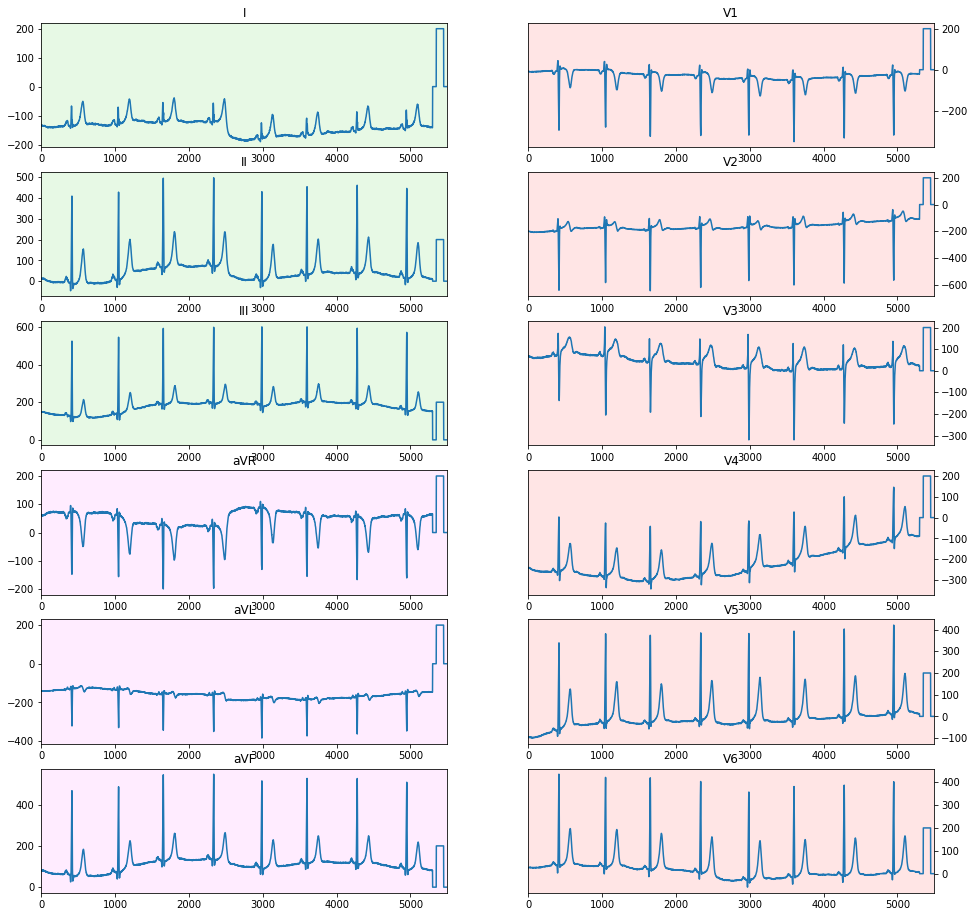

In [20]:
sak.visualization.signal.standard(signals[:12,].T, header=header[:12], figsize=(16,16))

In [3]:
import scipy as sp
import scipy.io

In [20]:
tmp = scipy.io.loadmat('/home/guille/DADES/DADES/RubenDoste/MKL/Training/Training_ECG.mat')

In [ ]:
for 

In [24]:
tmp['Training_ECG'].shape

(1560, 301, 12)

In [ ]:
sak.visualization.signal.standard(tmp[:,:,0],figsize=(16,10))

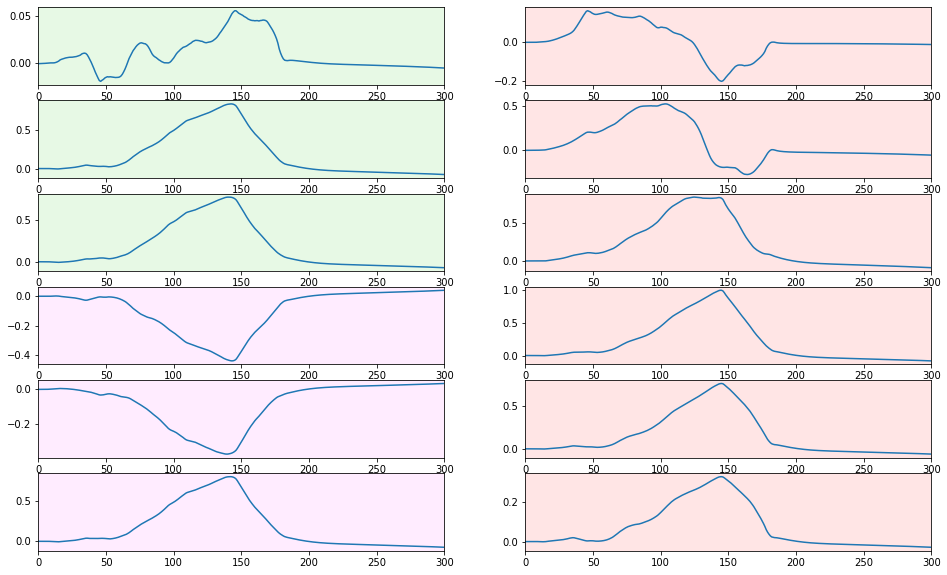

In [18]:
sak.visualization.signal.standard(tmp[:,:,0],figsize=(16,10))

In [8]:
tmp = scipy.io.loadmat('/home/guille/DADES/DADES/RubenDoste/Test/ECG_signal_raw.mat')['ECG_signal']

In [10]:
import sak.visualization

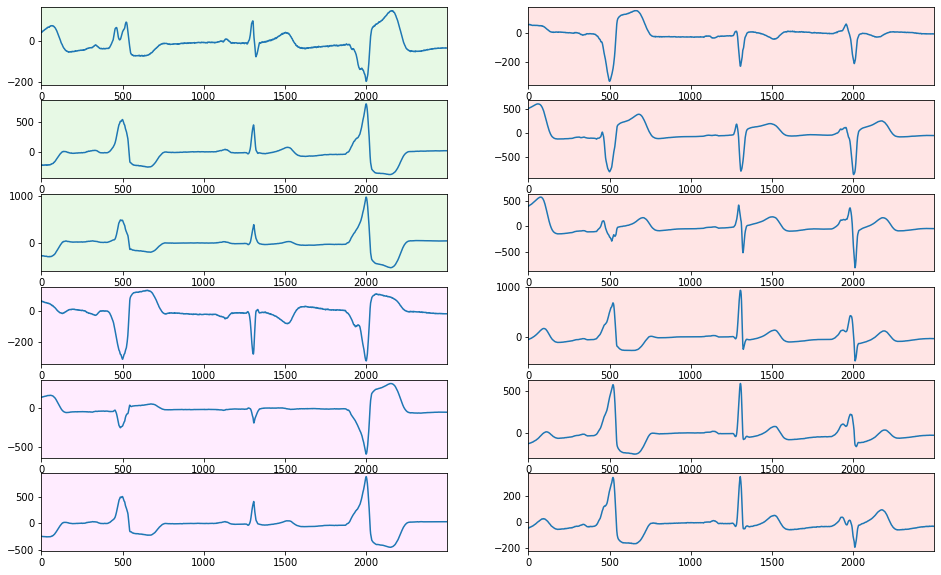

In [12]:
sak.visualization.signal.standard(tmp[:,:,0],figsize=(16,10))

In [3]:
config_file = './configurations/MultiScaleUNet5Levels.json' 
input_files  = './pickle/' 
model_name = 'test'

In [29]:
##### 1. Load configuration file #####
with open(config_file, "r") as f:
    execution = json.load(f)

execution["root_directory"] = os.path.expanduser(execution["root_directory"])
execution["save_directory"] = os.path.expanduser(execution["save_directory"])

##### 2. Load synthetic dataset #####
# 2.1. Load individual segments
P = sak.pickleload(os.path.join(input_files,"Psignal_new.pkl"))
PQ = sak.pickleload(os.path.join(input_files,"PQsignal_new.pkl"))
QRS = sak.pickleload(os.path.join(input_files,"QRSsignal_new.pkl"))
ST = sak.pickleload(os.path.join(input_files,"STsignal_new.pkl"))
T = sak.pickleload(os.path.join(input_files,"Tsignal_new.pkl"))
TP = sak.pickleload(os.path.join(input_files,"TPsignal_new.pkl"))

Pamplitudes = sak.pickleload(os.path.join(input_files,"Pamplitudes_new.pkl"))
PQamplitudes = sak.pickleload(os.path.join(input_files,"PQamplitudes_new.pkl"))
QRSamplitudes = sak.pickleload(os.path.join(input_files,"QRSamplitudes_new.pkl"))
STamplitudes = sak.pickleload(os.path.join(input_files,"STamplitudes_new.pkl"))
Tamplitudes = sak.pickleload(os.path.join(input_files,"Tamplitudes_new.pkl"))
TPamplitudes = sak.pickleload(os.path.join(input_files,"TPamplitudes_new.pkl"))

# 2.2. Get amplitude distribution
Pdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Pamplitudes.values()))))
PQdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(PQamplitudes.values()))))
QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.hstack((np.array(list(QRSamplitudes.values())), 2-np.array(list(QRSamplitudes.values()))))))
STdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(STamplitudes.values()))))
Tdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Tamplitudes.values()))))
TPdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(TPamplitudes.values()))))

# 2.3. Smooth all
window = 5
P   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  P[k],window)),metric=sak.signal.abs_max) for k in   P}
PQ  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( PQ[k],window)),metric=sak.signal.abs_max) for k in  PQ}
QRS = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(QRS[k],window)),metric=sak.signal.abs_max) for k in QRS}
ST  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( ST[k],window)),metric=sak.signal.abs_max) for k in  ST}
T   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  T[k],window)),metric=sak.signal.abs_max) for k in   T}
TP  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( TP[k],window)),metric=sak.signal.abs_max) for k in  TP}


##### 3. Load QTDB #####
dataset             = pd.read_csv(os.path.join(input_files,'QTDB','Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}
unique_ids          = list(set([k.split('_')[0] for k in dataset]))

# Load validity
validity            = sak.load_data(os.path.join(input_files,'QTDB','validity.csv'))

# Load fiducials
Pon_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','PonNew.csv'))
Poff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','PoffNew.csv'))
QRSon_QTDB          = sak.load_data(os.path.join(input_files,'QTDB','QRSonNew.csv'))
QRSoff_QTDB         = sak.load_data(os.path.join(input_files,'QTDB','QRSoffNew.csv'))
Ton_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','TonNew.csv'))
Toff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','ToffNew.csv'))

# Generate masks & signals
signal_QTDB = {}
segmentation_QTDB = {}
for k in tqdm.tqdm(QRSon_QTDB):
    # Check file exists and all that
    if k not in validity:
        print("Issue with file {}, continuing...".format(k))
        continue

    # Store signal
    signal = dataset[k][validity[k][0]:validity[k][1]].values
    signal = sak.signal.on_off_correction(signal)
    amplitude = np.median(sak.signal.moving_lambda(signal,200,sak.signal.abs_max))
    signal = signal/amplitude
    signal_QTDB[k] = signal[None,]

    # Generate boolean mask
    segmentation = np.zeros((3,dataset.shape[0]),dtype=bool)
    if k in Pon_QTDB:
        for on,off in zip(Pon_QTDB[k],Poff_QTDB[k]):
            segmentation[0,on:off] = True
    if k in QRSon_QTDB:
        for on,off in zip(QRSon_QTDB[k],QRSoff_QTDB[k]):
            segmentation[1,on:off] = True
    if k in Ton_QTDB:
        for on,off in zip(Ton_QTDB[k],Toff_QTDB[k]):
            segmentation[2,on:off] = True

    segmentation_QTDB[k] = segmentation[:,validity[k][0]:validity[k][1]]


##### 4. Generate random splits #####
# 4.1. Split into train and test
all_keys_synthetic = {}
for k in list(P) + list(PQ) + list(QRS) + list(ST) + list(T) + list(TP):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_synthetic:
        all_keys_synthetic[uid] = [k]
    else:
        all_keys_synthetic[uid].append(k)

all_keys_real = {}
for k in list(signal_QTDB) + list(segmentation_QTDB):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_real:
        all_keys_real[uid] = [k]
    else:
        all_keys_real[uid].append(k)

# 4.2. Get database and file
filenames = []
database = []
for k in all_keys_synthetic:
    filenames.append(k)
    if k.startswith("SOO"):
        database.append(0)
    elif k.startswith("sel"):
        database.append(1)
    else:
        database.append(2)
filenames = np.array(filenames)
database = np.array(database)

# Set random seed for the execution and perform train/test splitting
random.seed(execution["seed"])
np.random.seed(execution["seed"])
torch.random.manual_seed(execution["seed"])
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)

##### 5. Train folds #####
# 5.1. Define loss
criterion = lambda X,y,y_pred,sample_weight: sak.torch.nn.DiceLoss()(y_pred, y, sample_weight=sample_weight)
metric    = lambda X,y,y_pred,sample_weight: sak.torch.nn.DiceLoss()(y_pred, y, sample_weight=sample_weight)

# 5.2. Save model-generating files
target_path = execution["save_directory"] # Store original output path for future usage
original_length = execution["dataset"]["length"]
if not os.path.isdir(os.path.join(target_path,model_name)):
    pathlib.Path(os.path.join(target_path,model_name)).mkdir(parents=True, exist_ok=True)
# shutil.copyfile("./train_multi.py",os.path.join(target_path,model_name,"train_multi.py"))
# shutil.copyfile("./src/data.py",os.path.join(target_path,model_name,"data.py"))
# shutil.copyfile("./src/metrics.py",os.path.join(target_path,model_name,"metrics.py"))
# shutil.copyfile(config_file,os.path.join(target_path,model_name,os.path.split(config_file)[1]))

# 5.3. Structure to save splitter
all_folds_test = {}

# 5.4. Iterate over folds
for i,(ix_train,ix_valid) in enumerate(splitter):
    print("################# FOLD {} #################".format(i+1))
    # Synthetic keys
    train_keys_synthetic, valid_keys_synthetic = ([],[])
    for k in np.array(filenames)[ix_train]: 
        train_keys_synthetic += all_keys_synthetic[k]
    for k in np.array(filenames)[ix_valid]: 
        valid_keys_synthetic += all_keys_synthetic[k]

    # Real keys
    train_keys_real, valid_keys_real = ([],[])
    for k in np.array(filenames)[ix_train]: 
        if k in all_keys_real: train_keys_real += all_keys_real[k]
    for k in np.array(filenames)[ix_valid]: 
        if k in all_keys_real: valid_keys_real += all_keys_real[k]

    # Avoid repetitions
    train_keys_synthetic = list(set(train_keys_synthetic))
    valid_keys_synthetic = list(set(valid_keys_synthetic))
    train_keys_real = list(set(train_keys_real))
    valid_keys_real = list(set(valid_keys_real))

    # Save fold"s validation files for later usage
    all_folds_test["fold_{}".format(i+1)] = np.array(filenames)[ix_valid]

    # ~~~~~~~~~~~~~~~~~~~~ Refine synthetic set ~~~~~~~~~~~~~~~~~~~~
    # Divide train/valid segments
    Ptrain   = {k:   P[k] for k in   P if k in train_keys_synthetic}
    PQtrain  = {k:  PQ[k] for k in  PQ if k in train_keys_synthetic}
    QRStrain = {k: QRS[k] for k in QRS if k in train_keys_synthetic}
    STtrain  = {k:  ST[k] for k in  ST if k in train_keys_synthetic}
    Ttrain   = {k:   T[k] for k in   T if k in train_keys_synthetic}
    TPtrain  = {k:  TP[k] for k in  TP if k in train_keys_synthetic}

    Pvalid   = {k:   P[k] for k in   P if k in valid_keys_synthetic}
    PQvalid  = {k:  PQ[k] for k in  PQ if k in valid_keys_synthetic}
    QRSvalid = {k: QRS[k] for k in QRS if k in valid_keys_synthetic}
    STvalid  = {k:  ST[k] for k in  ST if k in valid_keys_synthetic}
    Tvalid   = {k:   T[k] for k in   T if k in valid_keys_synthetic}
    TPvalid  = {k:  TP[k] for k in  TP if k in valid_keys_synthetic}

    # ~~~~~~~~~~~~~~~~~~~~~~ Refine real set ~~~~~~~~~~~~~~~~~~~~~~~
    signal_QTDB_train       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in train_keys_real}
    signal_QTDB_valid       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in valid_keys_real}
    segmentation_QTDB_train = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in train_keys_real}
    segmentation_QTDB_valid = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in valid_keys_real}


    # Prepare folders
    execution["save_directory"] = os.path.join(target_path, model_name, "fold_{}".format(i+1))
    if not os.path.isdir(execution["save_directory"]):
        pathlib.Path(execution["save_directory"]).mkdir(parents=True, exist_ok=True)

    # Define synthetic datasets
    dataset_train_synthetic = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = execution["dataset"]["length"]//4 # On synthetic data, not so useful to do intensive validation
    dataset_valid_synthetic = src.data.Dataset(Pvalid, QRSvalid, Tvalid, PQvalid, STvalid, TPvalid, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = original_length # On synthetic data, not so useful to do intensive validation

    # Define real datasets
    dataset_train_real = src.data.DatasetQTDB(signal_QTDB_train,segmentation_QTDB_train,execution["dataset"]["N"],128)
    dataset_valid_real = src.data.DatasetQTDB(signal_QTDB_valid,segmentation_QTDB_valid,execution["dataset"]["N"],128)

    # Define merging dataset
    dataset_train = sak.torch.data.UniformMultiDataset((dataset_train_synthetic,dataset_train_real),[10,1],[1,10],return_weights=True)
    sampler_train = sak.torch.data.UniformMultiSampler(dataset_train)
    dataset_valid = sak.torch.data.UniformMultiDataset((dataset_valid_synthetic,dataset_valid_real),[10,1],[1,10],return_weights=True)
    sampler_valid = sak.torch.data.UniformMultiSampler(dataset_valid)

    # Create dataloaders
    loader_train = torch.utils.data.DataLoader(dataset_train, sampler=sampler_train, **execution["loader"])
    loader_valid = torch.utils.data.DataLoader(dataset_valid, sampler=sampler_valid, **execution["loader"])
    agkjdklsjagklsjgkl
    # Define model
    model = nn.ModelGraph(execution["model"]).float().cuda()

    # Train model
    state = {
        "epoch"         : 0,
        "device"        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "optimizer"     : sak.class_selector(execution["optimizer"]["class"])(model.parameters(), **execution["optimizer"]["arguments"]),
        "root_dir"      : "./"
    }
    if "scheduler" in execution:
        state["scheduler"] = sak.class_selector(execution["scheduler"]["class"])(state["optimizer"], **execution["scheduler"]["arguments"])

    # Train model (auto-saves to same location as above)
    sak.torch.train.train_model(model,state,execution,loader_train,loader_valid,criterion,metric,smaller=True)

sak.save_data(all_folds_test,os.path.join(target_path,model_name,"validation_files.csv"))


100%|██████████| 206/206 [00:00<00:00, 1586.53it/s]


Issue with file sel35_0, continuing...
Issue with file sel35_1, continuing...
################# FOLD 1 #################


NameError: name 'agkjdklsjagklsjgkl' is not defined

In [ ]:
for i,(x,y,z) in enumerate(tqdm.tqdm(loader_train)):
    pass

In [5]:
len(loader_train)

1128

In [6]:
sampler_train.groups

[65536, 6602]

In [7]:
sampler_train.iterations

6602

In [30]:
indices = []
for i,g in tqdm.tqdm(sampler_train):
    indices.append((i,g))
    pass

100%|██████████| 72622/72622 [00:00<00:00, 1575000.23it/s]


In [ ]:
len()

In [ ]:
math.ceil(max([len(d)/dataset_train.draws[i] for i,d in enumerate(dataset_train.datasets)]))

In [8]:
max([len(d)/dataset_train.draws[i] for i,d in enumerate(dataset_train.datasets)])

6602.0

In [9]:
math.ceil(max([len(d)/dataset_train.draws[i] for i,d in enumerate(dataset_train.datasets)]))

6602

In [ ]:
sampler_train